# **Underwater Image Enhancement with Reinforcement Learning**

# Description of the problem


The Underwater Image Enhancement problem concerns the enhancement of underwater images and is attracting much attention due to its importance in marine engineering and aquatic robotics. This is a challenging task due to a number of issues arising from the environment in which such photos are taken.

The main problems are caused by two phenomena: **scattering**, i.e. the presence of particles such as dust and plankton, and **absorption**, the absorption due to the wavelength which alters the color of the image by making it darker and changing its dominant color.

# Import delle librerie

In [ ]:
#force package installation 
!pip install split-folders

In this section, the necessary modules are imported.

Specifically, the library is imported
**OpenAI**
[**Gym**](https://www.gymlibrary.ml/), a toolkit, developed by the company [**OpenAI**](https://openai.com/), which provides an intelligence benchmark easy to set up with a wide variety of different environments for developing and comparing reinforcement learning algorithms.

In [ ]:
import os
#configuration that avoid useful log when run notebook on cluster 
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
'''

from tensorflow import keras
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras.applications.vgg19 import decode_predictions, preprocess_input #used for numpy tensor preprocessing
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, MeanAbsoluteError, MeanSquaredError
from keras.models import Model #used for extracting features from an arbitrary hidden layer in vgg
from keras.utils import get_file, load_img, plot_model

import numpy as np
import glob
import cv2 as cv
import time #used for calculate training and steps duration

from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from statistics import mean
from random import sample, randrange #used to sample indexes from ddqn memory and to choose the exploration action
from splitfolders import ratio as splitfolders_ratio
from shutil import rmtree
from imgaug import augmenters as iaa #used for sharpen and emboss actions
from itertools import combinations_with_replacement
from collections import defaultdict
from PIL import ImageEnhance, Image
from IPython.display import clear_output #used for cleaning too long cells output

from gym import Env #used for implementing environment
from gym.spaces import Box, Discrete

#Utility functions


Some utility functions are defined.
The most important are:

- `plot_training_rewards` plots the progress of the total reward and its moving average reached during the different episodes of the training process in a graph.
  * `rewards`: vector of rewards to be plotted
  * `moving_avg_window_size`: number of consecutive episodes considered in the calculation of the moving average of the total reward

- `show_image_grid` allows you to print a configurable grid of random images sampled from a source folder
  * `image_path`: path to the folder from which to sample images to display
  * `grid_size`: pair of values ​​that define the size of the grid in terms of the number of images on each axis
  * `image_size`: size of the images on the grid

- `compare_images` prints multiple images side by side, with title
  * `images`: vector of images to display
  * `titles`: vector of the titles of the images, useful for making the print readable
  * `image_size`: image display size

- `display_image` allows you to print an image
  * `image`: image to display

In [ ]:
def plot_training_rewards(rewards,moving_avg_window_size=None):
  if moving_avg_window_size is not None:
    moving_avg_total_reward=[]
    for i in range(len(rewards)):
      window=rewards[max(0,i-moving_avg_window_size+1):i+1]
      window_avg=mean(window)
      moving_avg_total_reward.append(window_avg)

  fig, ax = plt.subplots(figsize=(15, 5))

  ax.plot(range(len(rewards)),rewards,label='Total reward',color='orange')
  ax.set_xlabel('Episodes')
  if moving_avg_window_size is not None:
    ax.plot(range(len(moving_avg_total_reward)),moving_avg_total_reward,label='Total reward moving average')
    ax.legend(loc='upper left')

def show_image_grid(image_path, grid_size, image_size):
  fig = plt.figure(figsize=image_size)
  rows, columns = grid_size
  for i in range(1, columns*rows +1):
      fn = np.random.choice(image_path)
      img = Image.open(fn)
      fig.add_subplot(rows, columns, i)
      plt.axis('off')
      plt.imshow(img)
  plt.show()

#for comparing raw and ref visually
def compare_images(images, titles, image_size):
  number_of_images = len(images)
  fig, axes = plt.subplots(1, number_of_images, figsize=image_size)
  for i in range(number_of_images):
    axes[i].imshow(images[i])
    axes[i].set_title(titles[i])
    axes[i].axis('off')
  plt.show()

def display_image(image) -> None:
    """
    display an image
    
    Arguments:
        filename: str - path to filename containing image
    """
    plt.figure()
    plt.imshow(image)

# Dataset


The following [**dataset**](https://li-chongyi.github.io/proj_benchmark.html) contains 890 raw images (**raw images**) with corresponding high quality reference images (** reference images**).
In addition it contains 60 images without the analogous reference, defined as **challenge images**.

In recent years several algorithms have been proposed for the Underwater Image Enhancement problem. However these are often evaluated using synthetic datasets or a few images selected from the real world. It is therefore not very clear how these algorithms would perform on images acquired in the wild and how progress could be measured in the field. To fill this gap it was decided to use this dataset which contains large-scale real-world images. Thus it allows to carry out a complete study of the algorithms for improving underwater images.

In [ ]:
#variable with path to just-downloaded dataset and post-splitting dataset
dataset_path= '/content/underwater_dataset'
splitted_dataset_path = '/content/splitted_dataset'

## Download

In [ ]:
#create an empty folder to store the dataset
!mkdir underwater_dataset

### Raw image download

In [ ]:
zipped_dataset_path_raw= "/content/raw_underwater_rar.rar"
path_to_downloaded_file = get_file(
    zipped_dataset_path_raw,
    "https://drive.google.com/u/0/uc?id=12W_kkblc2Vryb9zHQ6BfGQ_NKUfXYk13&export=download&confirm=t&uuid=a911e909-c2fa-4fd4-8231-995cd8aba324")

#extract images from zip file
!unrar x -Y /content/raw_underwater_rar.rar -p1234567 underwater_dataset
#delete zip file after extraction
os.remove(zipped_dataset_path_raw)
#clean the output after dowload
clear_output(wait=False)

### Reference image download

In [ ]:
zipped_dataset_path_ref= "/content/ref_underwater_rar.rar"
path_to_downloaded_file = get_file(
    zipped_dataset_path_ref,
    "https://drive.google.com/u/0/uc?id=1cA-8CzajnVEL4feBRKdBxjEe6hwql6Z7&export=download&confirm=t&uuid=1d35640a-aba9-4b79-b86b-fe3d1d8b947e")

#extract images from zip file
!unrar x -Y /content/ref_underwater_rar.rar -p8901234 underwater_dataset
#delete zip file after extraction
os.remove(zipped_dataset_path_ref)
#clean the output after dowload
clear_output(wait=False)

## Splitting


The dataset is divided into three sets: training, validation and test set. The training sessions are conducted on the **training set**, changing the hyperparameters in order to obtain different models with different performances. Among these models, the one that achieves the best performance on the **validation set** is selected, evaluated with respect to the selected metrics. Finally the performance analysis is conducted using the model selected on the **test set**.

`split_dataset` is the function used to split the dataset into training sets, validation sets and test sets (dimensions are expressed in tenths: e.g. 0.2 corresponds to 20% of the total)
  * `training_set_size`: size of the training set
  * `test_set_size`: size of the test set
  * `validation_set_size`: size of the validation set

The `splitfolder` library is used to partition the dataset and obtain the following folder hierarchy:

* /content/splitted_dataset
  * /train
    * /raw-890
    * /reference-890
  * /test
    * /raw-890
    * /reference-890
  * /val
    * /raw-890
    * /reference-890

In [ ]:
def split_dataset(training_set_size, test_set_size, validation_set_size):

  if os.path.isdir(splitted_dataset_path):
      rmtree(splitted_dataset_path)

  splitfolders_ratio(
      dataset_path,
      output=splitted_dataset_path,
      ratio=(training_set_size, test_set_size, validation_set_size)
  )
  
  #rmtree(dataset_path)

The table below shows the data relating to the subdivision made for the experiment:

Together      | percentuale | number of images
---            | ---         | ---
Training set   | 60%         | 534
Test set       | 20%         | 178
Validation set | 20%         | 178
**totale**     | **100%**    | **890**

In [ ]:
training_set_size = 0.6
test_set_size = 0.2
validation_set_size = 0.2

split_dataset(training_set_size, test_set_size, validation_set_size)

## Analisi

In [ ]:
# sort and store images in utility variables and print image number for validation purpose
# glob: finds all pathnames matching a specified pattern
images_raw = sorted(glob.glob(dataset_path + '/raw-890/*.png'), key=len)
images_ref = sorted(glob.glob(dataset_path + '/reference-890/*.png'),key=len)
print("Total number of raw images: ", len(images_raw))
print("Total number of reference images: ", len(images_ref))

images_raw_train = sorted(glob.glob(splitted_dataset_path + '/train/raw-890/*.png'), key=len)
images_raw_test = sorted(glob.glob(splitted_dataset_path + '/test/raw-890/*.png'), key=len)
images_raw_val = sorted(glob.glob(splitted_dataset_path + '/val/raw-890/*.png'), key=len)
print("Total number of raw images for training: ", len(images_raw_train))
print("Total number of raw images for validation: ", len(images_raw_val))
print("Total number of raw images for testing: ", len(images_raw_test))

images_ref_train = sorted(glob.glob(splitted_dataset_path + '/train/reference-890/*.png'),key=len)
images_ref_test = sorted(glob.glob(splitted_dataset_path + '/test/reference-890/*.png'),key=len)
images_ref_val = sorted(glob.glob(splitted_dataset_path + '/val/reference-890/*.png'),key=len)
print("Total number of reference images for training: ", len(images_ref_train))
print("Total number of reference images for validation: ", len(images_ref_val))
print("Total number of reference images for testing: ", len(images_ref_test))

`sample_images` is a function used to sample a raw image and its reference from the selected set (training, test or validation)
  * `source` indicates the set from which to sample the image, "test" for the test set, "val" for the validation set, and any other values ​​for the training set
  * `target_size` defines the size of the image, if omitted the original size is used

In [ ]:
def sample_images(source="train", target_size=None):
  
  if source == "test":
    random_img_path = np.random.choice(images_raw_test)
  elif source == "val":
    random_img_path = np.random.choice(images_raw_val)
  else:
    random_img_path = np.random.choice(images_raw_train)

  random_img=random_img_path.split('/').pop()

  file_raw = splitted_dataset_path + '/' + source + '/raw-890/' + random_img
  raw_img= load_img(path=file_raw,target_size=target_size)
  file_ref = splitted_dataset_path + '/' + source + '/reference-890/' + random_img
  ref_img = load_img(path=file_ref,target_size=target_size)

  return raw_img,ref_img

As an example, some raw images randomly sampled from the dataset are displayed. Subsequently, given a randomly selected raw image, the reference image associated with it is also displayed, in such a way as to carry out a visual comparison.

In [ ]:
#random raw images visualization
show_image_grid(image_path=images_raw, grid_size=(3, 6), image_size=(16, 8))

#raw-reference images visualization
for i in range(1, 4):
      raw_img,ref_img = sample_images()
      compare_images([raw_img, ref_img], ['Raw image', 'Reference image'], (14, 14))
plt.show()

#**Underwater Image Enhancement con il Reinforcement Learning**

Existing approaches used to address Underwater Image Enhancement have some **limitations**:

* Due to the complexity of the underwater environment, a single image processing method is unable to adapt to different scenes (such as different turbidities, different light conditions, and shooting from different angles), resulting in inconsistent performance (inaccurate or incorrect enhancements ).

* Models based on Deep Learning methods which are normally structured with an end-to-end network, apply an elaboration that is in fact a black box, reducing the explainability of the model and preventing the drawing of ideas for its improvement.

* Training a deep network requires a large number of pairs of training data, formed by a raw image and a reference image, considered the ground truth and obtained through selection made by expert users, since it is not possible to have an image actual ground truth. The reference image for models of this type acts as an upper limit on the quality of the image obtained starting from the raw image, preventing the generation of better images.

Reinforcement Learning presents itself as an effective method to overcome these limitations. In fact, a strategy is provided to organize an optimal sequence of actions that exploit basic image enhancement methods to achieve an effective overall image enhancement as a goal, as can be seen in the figure below. Each action in the optimal sequence consists of a specific image processing technique so that the whole sequence of actions is transparent.

Furthermore, the possibility of carrying out both exploration and exploitation could also allow to obtain images of better quality than the reference image.

The model solves a Markov Decision Process (MDP) which consists in the interaction at each step $t$ between an **agent** and an **environment**. The MDP consists of four components:

* a **state** $s_t \in S$ which consists of the set of information that the agent perceives from the environment: in our case the state consists of the features extracted from the images of the environment.
* an **action** $a_t \in A$ which consists of any behavior that the agent can perform in the environment: in our case we are dealing with image enhancement operations.
* a **reward** $r_t \in R$ which is a feedback that the agent receives from the environment after performing an action: in our case the reward defines how much the action produces a result closer to the image ground truth with respect to the starting image.
* a **policy** $\Omega_\theta$ i.e. the strategy that the agent applies to decide what will be its next action based on its current state.

<div>
<img src="https://drive.google.com/uc?id=1UwwcV3C-_l-Z7VXDclhyf74ewYX-03vt" width="1000"/>
</div>

## **Framework generale**



The general framework used consists of four parts:

1. **Feature extraction module**: Extracts features from an image. The extracted features will make up the states
2. **Deep Q-Network**: takes a state as input and returns a $Q(s,a)$ value for each action
3. **Action selection form**: Choose an action using a ϵ-greedy policy
4. **Calculation of the reward** in terms of image improvement. This part is present only in the training phase

An example framework graph is shown below:

<div>
<img src="https://drive.google.com/uc?id=1CakA90pErEueJYFttAVgBEuugUt9hNHG" width="1000"/>
</div>

In [ ]:
#loading a random image for testing purpose
random_image,random_reference = sample_images(target_size=(224,224))
compare_images([random_image, random_reference], ['Raw image', 'Reference image'], (10, 10))

### Actions

**Image enhancement** techniques are used as actions. Below are the four categories of techniques used, each of which is followed by a detailed list of the technical specifications belonging to the category itself:

**Basic settings**
1. Brightness +5%
2. Brightness -5%
3. Contrast +5%
4. Contrast -5%
5. Color saturation +5%
6. Color saturation -5%

**Color Adjustments**
7.Red +5%
8.Red -5%
9.Green +5%
10.Green -5%
11.Blue +5%
12.Blue -5%

**Corrections**
13. Gamma + transformation
14. Gamma Transformation -
15. HE
16. CLAHE
17. White Balance

**Deblurring**
18. Sharpen
19. Emboss
20. DCPs

The less intuitive actions are described in the following subsections.

`apply_action` is a function that allows you to apply an action on an image and return the enhanced image as a result.
  * `action_code` is the code of the action to apply
  * `img` is the image on which to apply the selected action

In [ ]:
actions_number = 20

seq_sharpen = iaa.Sequential([
  iaa.Sharpen(alpha=.05)
])
seq_emboss = iaa.Sequential([
  iaa.Emboss(alpha=.05)
])

#img -> image loaded with PIL module
def apply_action(action_code, img):

  #brightness +/- 5%
  if action_code in [0,1]:
    factor = 1.05 if action_code == 0 else 0.95 
    converter = ImageEnhance.Brightness(img)
    return converter.enhance(factor)

  #contrast +/- 5%
  elif action_code in [2,3]:
    factor = 1.05 if action_code == 2 else 0.95
    converter = ImageEnhance.Contrast(img)
    return converter.enhance(factor)

  #color saturation +/- 5%
  elif action_code in [4,5]:
    factor = 1.05 if action_code == 4 else 0.95
    converter = ImageEnhance.Color(img)
    return converter.enhance(factor)
  
  #change color channel intensity
  elif action_code in [6,7,8,9,10,11]:
    factor = 1.05 if action_code in [6,8,10] else 0.95

    #split into 3 channels
    red,green,blue = img.split()

    #increase channel intensity
    if action_code in [6,7]: red = red.point(lambda i: i*factor)
    elif action_code in [8,9]: green = green.point(lambda i: i*factor)
    else: blue = blue.point(lambda i: i*factor)

    return Image.merge("RGB", (red,green,blue))

  else:
    img_array = np.array(img) #the PIL image should be transformed in numpy array

    #gamma correction
    if action_code in [12,13]:
      gamma = 1.5 if action_code == 12 else 0.5
      return gammaCorrection(img_array,gamma)
    #he,claheq, white balance
    elif action_code in [14,15,16]:
      opencv_image=cv.cvtColor(img_array, cv.COLOR_RGB2BGR) #convert to opencv image
      if action_code == 14: 
        #he
        return heq(opencv_image)
      elif action_code == 15:
        #clahe
        return claheq(opencv_image)
      else: 
        #white balance
        return white_balance(opencv_image)

    #sharpen & emboss
    elif action_code in [17,18]:
      img_array = np.expand_dims(img_array, axis=0)
      if action_code == 17: modified_array = seq_sharpen(images=img_array)
      else: modified_array = seq_emboss(images=img_array)   
      return Image.fromarray(modified_array[0])

    #DCP
    elif action_code == 19:
      ## convert to a openCV image
      opencv_image=cv.cvtColor(img_array, cv.COLOR_RGB2BGR) 
      #with pipe filtering
      #return dehaze(opencv_image)
      ##without pipe filtering -> operation will be more fast
      return dehaze(opencv_image,refine=False)

    else:
      print("unsupported action", action_code)
      return img

#### White balance

White Balance (WB) is used to eliminate color casts to return to an all-white light beam, i.e. where all colors are present in the same amount.
The Grayworld algorithm is used for the implementation.

**Grayworld assumption**

Assuming a good distribution of colors in the scene, the *Grayworld assumption* is based on the assumption that, on average, the real world tends to gray and estimates the color of the light using the average color of all pixels. It is assumed that the information, given by the average of each channel of the image, is representative of the gray level.

The reason for transforming the input image to the CIELAB color space is to estimate the light source. It consists of two chromatic components a and b, and a third component that expresses the degree of luminosity, unrelated to them. The latter does not contain any color information.


In [ ]:
#white balance here
#https://pippin.gimp.org/image-processing/chapter-automaticadjustments.html#

def white_balance(opencv_image): 
    '''
    ps:need to do some fixes for cv corrections
    #L: L / 100 * 255
    #A: A + 128
    #B: B + 128
    '''
    result = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
    '''1) first find average color in CIE Lab space'''
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    '''2) scale the chroma distance shifted according to amount of luminance. The 1.1 overshoot is because 
    we cannot be sure to have gotten the data in the first place.'''
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    resultPil=cv.cvtColor(result,cv.COLOR_LAB2RGB)
    pil_image=Image.fromarray(resultPil)

    return pil_image

In [ ]:
white_balanced_opencv=apply_action(action_code=16,img=random_image)

compare_images([random_image, white_balanced_opencv], ['Raw image', 'White balanced image'], (10, 10))

####Dark Channel Prior (DCP)

This technique, which is usually used for haze removal in images of outdoor scenes, has also been widely used for underwater image recovery.

For further information on the DCP, refer to the paper [3] in the section *Literature references*

* It is implemented in the **dehaze()** function.

* The guided_filter() function is additional, and is used to refine the image obtained by dehaze(), which can sometimes be a bit grainy.

In [ ]:
"""Implementation for Guided Image Filtering
   -  The main reason is that the transmitter map obtained by the dehazing
    is too rough, and He Kai Ming puts forward Soft Matting method in the article, and then its disadvantage is very slow, 
    not applicable in real-time occasions, 2011, It can be used to obtain more delicate results in a manner that is used, 
    and this method is mainly concentrated in block filtering (mean filtering).
     Can be used in consideration.
   -  guided_filter() used here comes from https://github.com/joyeecheung/dark-channel-prior-dehazing/blob/master/src/guidedfilter.py
   -  for more informations about the algorithm read the docs here https://github.com/joyeecheung/dark-channel-prior-dehazing/tree/master/doc
"""
R, G, B = 0, 1, 2  # index for convenience

def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """        
    M, N = I.shape
    dest = np.zeros((M, N))
    # cumulative sum over Y axis
    sumY = np.cumsum(I, axis=0)
    # difference over Y axis
    dest[:r + 1] = sumY[r: 2 * r + 1]
    dest[r + 1:M - r] = sumY[2 * r + 1:] - sumY[:M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1:M - r - 1]
    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    # difference over Y axis
    dest[:, :r + 1] = sumX[:, r:2 * r + 1]
    dest[:, r + 1:N - r] = sumX[:, 2 * r + 1:] - sumX[:, :N - 2 * r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - \
        sumX[:, N - 2 * r - 1:N - r - 1]
    return dest

def guided_filter(I, p, r=40, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """    
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)
    # each channel of I filtered with the mean filter
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base
    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]
    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(
            I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]
    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                          [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                          [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, np.linalg.inv(Sigma + eps * np.eye(3)))  # eq 14
    # ECCV10 eq.15
    b = mean_p - a[:, :, R] * means[R] - \
        a[:, :, G] * means[G] - a[:, :, B] * means[B]
    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r) * I[:, :, R] + boxfilter(a[:, :, G], r) *
         I[:, :, G] + boxfilter(a[:, :, B], r) * I[:, :, B] + boxfilter(b, r)) / base
    return q

**dehaze()**

In computer vision the formation of a blurry image is usually described by the following pattern:

$$\mathbf{I}(\mathbf{x}) = \mathbf{J}(\mathbf{x})t(\mathbf{x}) + \mathbf{A}(1 - t(\mathbf{x }))$$

 where $I(x)$ is the observed blurry image, $J(x)$ is the scene brightness ("the clean image") to recover, $A$ is the global atmospheric light, and $t$ is the average transmission.

In [3] He proposed a method to reduce haze from outdoor images. Given an image $J$ its dark channel is calculated as:

$$
J^{dark}(\mathbf{x}) = min_{c \in \{r,g,b\}}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(J ^c(\mathbf{y})))
$$

$J$ is an outdoor image without haze, the intensity of $J^{dark}$ in the region of the image not including the sky is close to 0.

The idea is formed from the assumption that in the images there are many dark areas where there is no sky whose pixels will have at least one color channel with a very low value.

Then the transmission can be estimated as:

$$
\tilde{t}(\mathbf{x}) = 1 - \omega min_{c}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(\frac{I^c(\ mathbf{y})}{A^c}))
$$

where $\omega \in (0, 1]$ is a constant to maintain a certain amount of fog to keep the result as natural as possible. Here $min_{c}( min_{\mathbf{y} \in \ Omega(\mathbf{x})}(\frac{I^c(\mathbf{y})}{A^c}))$ is the dark channel of the normalized image with haze $\frac{I^c (\mathbf{y})}{A^c}$.

To obtain $A$ from the input image, first select the brightest p% pixels in the dark channel, then, for each color channel, choose the one with the highest intensity in the input image ${ I}$ like its atmospheric light.

Once $\tilde{t}(\mathbf{x})$, ${A}$ and ${I}$ have been obtained, the image without haze can be calculated with the following formula:

$$
\mathbf{J}(\mathbf{x}) = \frac{\mathbf{I}(\mathbf{x}) - \mathbf{A}}{max(\tilde{t}(\mathbf{x}) ,t_0)} + \mathbf{A}
$$

where $t_0$ is a lower bound for $t$ to preserve some amount of haze in areas where it is densest.



In [ ]:
#Single-Image-Haze-Removal-Using-Dark-Channel-Prior

%matplotlib inline

#The data structure used to store the original pixel position when sorting
class Node(object):
    def __init__(self,x,y,value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print('%s:%s:%s' %(self.x,self.y,self.value))
        
# get the minimum matrix
def getMinChannel(img):
    '''Get the minimum value of the three channels of BGR 
    
      parameters
      img - the image as a numpy array
      '''
    if len(img.shape)==3 and img.shape[2]==3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
    
    return np.min(img, axis=2)
   
def getDarkChannel(img,blockSize = 3):
    """Get the dark channel prior in the image data.
    Parameters
    -----------
    img:  the image as a numpy array
        H is the height, W is the width
    blocksize:  window size
    """
  
    if len(img.shape)==2:
        pass
    else:
        print("bad image shape, input image must be two dimensions")
        return None

    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None

    # calculate AddSize
    A = int((blockSize-1)/2) #AddSize
    #New height and new width
    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1
    # intermediate results
    imgMiddle = 255 * np.ones((H,W))    

    imgMiddle[A:H-A, A:W-A] = img
    
    imgDark = np.zeros_like(img, np.uint8)    
    
    localMin = 255
    for i in range(A, H-A):
        for j in range(A, W-A):
            x = range(i-A, i+A+1)
            y = range(j-A, j+A+1)
            imgDark[i-A,j-A] = np.min(imgMiddle[x,y])                            
    #return an H*W array for the dark channel prior
    return imgDark


def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):
    '''get global atmospheric light intensity

    Parameters
    darkChannel     the dark channel prior of the image as a height * width numpy array
    img             the image as a numpy array
    percent         the percentage of pixels for estimating the atmosphere light

    '''

    size = darkChannel.shape[0]*darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    # Store data in a linked list structure (list)
    for i in range(0,height):
        for j in range(0,width):
            oneNode = Node(i,j,darkChannel[i,j])
            nodes.append(oneNode)	
    # sort
    nodes = sorted(nodes, key = lambda node: node.value,reverse = True)

    atomsphericLight = 0

    # When the original image has too few pixels, only the first pixel is considered
    if int(percent*size) == 0:
        for i in range(0,3):
            if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x,nodes[0].y,i]
        
        return atomsphericLight

    #turn on average mode
    if meanMode:
        sum = 0
        for i in range(0,int(percent*size)):
            for j in range(0,3):
                sum = sum + img[nodes[i].x,nodes[i].y,j]
        atomsphericLight = int(sum/(int(percent*size)*3))
        return atomsphericLight

    # Get the highest brightness value of the pixel at the position of the first 0.1% (percent) of the dark channel in the original image
    for i in range(0,int(percent*size)):
        for j in range(0,3):
            if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x,nodes[i].y,j]
    return atomsphericLight


def dehaze(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=True):
    '''
    dehaze the given image

    Parameters
    img - the image as a numpy array
    omega- the defogging ratio parameter
    t0 - the minimum transmittance value
    blockSize - the window size
    percent - percentage of pixels for estimating the atmosphere light
    if you don't want to use guided filter set refine=False
    '''

    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize = blockSize)
    atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    # To prevent the occurrence of t less than 0
    # Limit the minimum value of t to 0.1
    transmission[transmission<0.1] = 0.1     
    
    if refine:        
        normI = (img - img.min()) / (img.max() - img.min())  # normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)
    
    for i in range(3):        
        SR = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight

        # Limit transmittance at 0～255                 
        SR[SR>255] = 255
        SR[SR<0] = 0                    
        sceneRadiance[:,:,i] = SR  
            
    sceneRadiance = np.uint8(sceneRadiance)
    resultPil=cv.cvtColor(sceneRadiance,cv.COLOR_BGR2RGB)
    return Image.fromarray(resultPil)    

In [ ]:
#apply action 
'''ps: pipe filtering implementation set to false '''
dcp_opencv=apply_action(action_code=19,img=random_image)

compare_images([random_image, dcp_opencv], ['Raw image', 'DCP image'], (10, 10))

#### Gamma Correction



Gamma transform corrects underwater images that are too bright (overexposure) or too dark (underexposure)

Correction is used to encode or decode the luminance of an image based on the used γ (gamma) parameter.

A γ value greater than 1 is called **γ encoding** and the correction process is called **γ compression**, while a γ value lower than 1 is called **γ decoding** and the process is called **γ expansion**.

The method for solving for gamma correction is quick: just build a table that maps the input image pixel values ​​to the output gamma corrected values. From the table, the output value for a given pixel is quickly determined.

Then the table is created by iterating all the pixels in the range [0.255]. The pixel value is then scaled to the interval [0,1.0] and is then multiplied by the inverse of the gamma - this value is then stored in the table.
Then the openCV **cv.LUT** function is applied which takes the image and the table as parameters and finds the correct mappings for each pixel value. 

In [ ]:
#gamma for gamma correction + equal to 1.5
#gamma for gamma correction - equal to 0.5
def gammaCorrection(opencv_image,gamma):
  # build a lookup table mapping the pixel values [0, 255] to
	  # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    correctedArray = cv.LUT(opencv_image, table)
    return Image.fromarray(correctedArray)

In [ ]:
image_1=apply_action(action_code=12, img=random_image)
image_2=apply_action(action_code=13, img=random_image)

compare_images([image_1,random_image,image_2], ['Gamma -','Raw image','Gamma +'], (10,10))

#### Histogram Equalization and Contrast Limited Adaptive Histogram Equalization (HE e CLAHE) 



The **histogram** is a graphical representation of the tonal distribution of the image: the variation of the tone is found on the abscissas, while the number of pixels relating to that tone is found on the ordinates.

Usually the intensity values ​​of the images are very close to each other. The **Histogram Equalization** is an image processing method that allows you to calibrate the contrast using the image histogram by distributing the most frequent intensity values ​​in a more uniform way.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/71/Histogrammspreizung.png" width="500"/>
</div>

The standard HE amplifies the contrast in the neighborhood of the constant areas and this can lead to the amplification of the noise present in the said neighborhood. In the **Contrast Limited Adaptive Histogram Equalization** a limit on the contrast amplification is introduced, in order to reduce the above problem.

The OpenCV library provides a function to apply histogram equalization, the **equalizeHist**. HE works well on a grayscale image, but not on an RGB image. One solution may be to convert the image to the YUV color space and apply equalization on the Y channel, and finally convert the image to RGB.


In [ ]:
#he
def heq(opencv_image):
 img_to_yuv = cv.cvtColor(opencv_image,cv.COLOR_BGR2YUV)
 img_to_yuv[:,:,0] = cv.equalizeHist(img_to_yuv[:,:,0])
 hist_equalization_result = cv.cvtColor(img_to_yuv, cv.COLOR_YUV2BGR)
 resultPil=cv.cvtColor(hist_equalization_result,cv.COLOR_BGR2RGB)
 pil_image=Image.fromarray(resultPil)
 return pil_image

The same problem mentioned above occurs in CLAHE, here the image will be converted to LAB color space, and the equalization is applied on the L channel.

In [ ]:
 #Clahe
 def claheq(opencv_image):
   img = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
   #configure CLAHE
   # clipLimit defines threshold to limit the contrast in case of noise in our image
   # tileGridSize defines the area size in which local equalization will be performed
   clahe = cv.createCLAHE(clipLimit=2.0,tileGridSize=(4,4))#)
   #0 to 'L' channel, 1 to 'a' channel, and 2 to 'b' channel
   img[:,:,0] = clahe.apply(img[:,:,0])
   img = cv.cvtColor(img, cv.COLOR_LAB2BGR)
   resultPil=cv.cvtColor(img,cv.COLOR_BGR2RGB)
   return Image.fromarray(resultPil)

In [ ]:
#he visualization
image_1=apply_action(action_code=14, img=random_image)
#clahe visualization
image_2=apply_action(action_code=15, img=random_image)
compare_images([image_1,random_image,image_2], ['HE image','Raw image','CLAHE image'], (10,10))

#### Sharpen


The sharpen filter makes transitions from one region of the image to another more obvious

In [ ]:
sharpenedImage = apply_action(action_code=17, img=random_image)

compare_images([random_image,sharpenedImage], ['Raw image','Sharpened image'], (10,10))

#### Emboss

With the Emboss a filter is applied on the image in order to obtain a 3D relief model of the same.

In [ ]:
embossedImage = apply_action(action_code=18, img=random_image)

compare_images([random_image,embossedImage], ['Raw image','Embossed image'], (10,10))

### Stati


The individual states are composed of all the features extracted from the input image. In the instant $t_i$ an action is applied on the starting image, obtaining an "enhanced" image from which the features that will constitute the state at the instant $t_{i+1}$ will be extracted.

### Feature extraction



Two different types of features are extracted from the image, which will constitute the initial state which will then be perceived by the agent:
* **Colour feature**: global features, describe the surface properties of the image
* **Perceptual feature**: Context-dependent features inspired by human vision.

#### Colour feature


As for the color features, the image is converted to switch from the RGB color space to the Lab (CIELAB) one.

The RGB space, coded on three bytes, allows to represent 40% of the colors that the human eye can perceive.
The CIE offers color spaces to broaden the field of possibilities to what man can actually perceive. Among these is the CIELAB color space, which tries to best represent the perception of color for the human eye and also estimates the light source.

The CIE model L*a*b* is a three-dimensional space where the *L* dimension specifies the degree of **brightness**, in the *a* dimension the **opposite colors red and green** are reported, while in the *b* shows the **opposite colors yellow and blue**.

* **L axis**: has values ​​between 0=black and 100=white
* **axis a**: has negative=green, or positive=red values
* **b-axis**: has negative=blue, or positive=yellow values

<div>
<img src="https://drive.google.com/uc?id=15vjH7JX4wc19BDTYZ-1KgRg1P0iIi_uL" width="400"/>
</div>

CIELAB may be suitable for training learning models. According to recent studies it has proven to be more effective than the RGB color space.

The **histogram** represents the intensity distribution of the pixels in the image. Each axis of the CIELab space is divided into 20 intervals and the number of pixels it contains is calculated for each interval. In our case a binning of 20 intervals was used for each channel, obtaining a 20x20x20 histogram which contains the values ​​of the color features.

CV2's `calcHist` function was used to calculate the histogram:

```
CV2.calcHist(images, channels, mask, histSize, ranges)
```
the function accepts the following parameters:

* `images`: vector of images for which you want to calculate the histogram (in this notebook a single image is mainly used, but it still needs to be converted to a vector of a single element)
* `channels`: list of channel indexes to compute (e.g. [0] to compute a grayscale image, [0,1,2] to compute an RGB or LAB image)
* `mask`: if provided only masked pixels are computed
* `histSize`: number of bins to use during histogram computation (list with number of bins for each of the channels)
* `ranges`: range of possible pixel values ​​for each channel (e.g. for RGB [0.256] is used); the values ​​for the three channels must be passed as a linear list and not as 3 separate lists nested in a fourth list

The histogram is calculated separately on the three channels to display the graph

In [ ]:
                                                                          1image_array = np.array(random_image)
#in opencv lab values are scaled to range [0,255]
lab=cv.cvtColor(image_array, cv.COLOR_RGB2LAB) #convert RGB values to LAB values
l_range=[np.min(lab[:,:,0]),np.max(lab[:,:,0])]
a_range=[np.min(lab[:,:,1]),np.max(lab[:,:,1])]
b_range=[np.min(lab[:,:,2]),np.max(lab[:,:,2])]
print("Ranges for l,a,b: ",l_range,a_range,b_range)

#visualizing graph and calculating histogram separately for every channel
bin_count=256

for i,col in enumerate(['l','a','b']):
  hist = cv.calcHist([lab],[i],None,[bin_count],[0,256])
  print('Shape:', hist.shape)
  plt.plot(hist,label=col)
  plt.xlim([0,bin_count])

plt.legend()
plt.title('Cielab histogram ')
plt.show()


The 3D histogram is calculated by obtaining the vector of the color features, made up of 8000 values.



In [ ]:
def get_color_feature(img_array, flatten=False):  
  #in opencv lab values are scaled to range [0,255]
  lab=cv.cvtColor(img_array, cv.COLOR_RGB2LAB) #convert RGB values to LAB values
  #calculating 3D histogram
  channels=[0, 1, 2]
  bins=[20, 20, 20]
  ranges = [0,256,0,256,0,256]

  histogram = cv.calcHist([lab], channels, None,bins , ranges)

  #print("total pixels in histogram:", np.sum(histogram)) #should be 50176 for 224x224 images
  if flatten: return histogram.flatten()
  else: return histogram

In [ ]:
#test that get_color_feature extract 8000 features
image_array = np.array(random_image)
print("color feature are:", get_color_feature(image_array).size)

#### Perceptual feature


A pre-trained **VGG-19** convolutional network** is used for the extraction of the perceptual features.

In the following subsections the model is described, the VGG-19 is built and compiled which will be used in the rest of the notebook and will be tested on some images as an example.

##### Modello VGG-19



VGGNet-19 takes 224x224x3 images as input and is composed of the following layers:

* 16 levels of Convolution
* 5 levels of Max Pooling
* 3 Fully Connected Levels

VGG also introduces the concept of block, i.e. a sequence of convolutional levels with kernel size 3x3 followed by a Max Pooling level with stride 2.

The main advantage of using VGG-19 is the high number of layers, which allows him to learn more complex representations of the input data. Compared to VGG-16 for example, VGG-19 is more accurate, but requires more memory and computational resources.

The figure shows the architecture of VGGNet-19:

<div>
<img src="https://drive.google.com/uc?id=1AUik3SqUJcYaWnKTrM37ZXyKctd8To6C" width="500"/>
</div>

**Why use a pre-trained network?**

Not having a labeled dataset, we opted for a model pre-trained on the ImageNet dataset to extract the features. Models trained on ImageNet have learned to extract features from a variety of images, and should do well in the application domain of underwater imaging as well.

Keras allows to instantiate the [**VGG**](https://keras.io/api/applications/vgg/) with the weights of the network pre-trained on ImageNet. The `include_top` parameter indicates whether you want to keep the top dense layers when loading the model or not.

In [ ]:
#pretrained network from ImageNet
vgg19 = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None, #default input shape is 224x224x3
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

##### Visualizzazione del modello

In [ ]:
vgg19.summary()

In [ ]:
plot_model(vgg19,show_shapes=True)

##### Compilazione del modello



As a final step, the model is compiled by choosing:

* Optimization algorithm: **ADAM**
* Loss function: **Categorical Cross-Entropy**
* Model performance evaluation metrics: **Accuracy**





In [ ]:
opt = Adam(learning_rate=0.001) 

vgg19.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

##### Feature extraction

Taking a random image from the dataset, the features are extracted by taking the output of one of the fully connected layers, as indicated in the paper. 4096 perceptual features are obtained, a number corresponding to the output neurons of the extraction level.



In [ ]:
#defining a new model whose output is the same of the first dense layer in vgg19
hidden_features_vgg = Model(inputs=vgg19.input, outputs=vgg19.get_layer('fc1').output)

def get_perceptual_features(img_array, model=hidden_features_vgg,flatten=False):
  image_values = np.expand_dims(img_array, axis=0) #add one axis to conform array with VGG input (first axis is the image number)
  image_values = preprocess_input(image_values) #scale pixel values appropriately for the VGG model
  
  features = model.predict(image_values,verbose="0")
  if flatten: return features.flatten() #convert 1x1000 matrix to a vector with of 1000 features
  else: return features

features = get_perceptual_features(random_image)
print("number of perceptual feature: ", features.size)
#print(features)

##### Example of feature extraction and classification

In [ ]:
#summarize filters shapes
for layer in vgg19.layers:
  #check for convolutional layer
  if 'conv' not in layer.name:
    continue
  #get filters weights
  filters,biases=layer.get_weights()
  print(layer.name,filters.shape)

View the size of feature maps for each level of convolution.

In [ ]:
#Summarize feature map size for each conv layer with VGG19
for i in range(len(vgg19.layers)):
  layer=vgg19.layers[i]
  #check  for convolutional layer
  if 'conv' not in layer.name:
    continue
  #summarize output shape
  print(i,layer.name, layer.output.shape)

The prediction is carried out and the 5 most probable classes of belonging are obtained.

In [ ]:
display_image(random_image)
# convert the probabilities to class labels. For default it return to top 5 guessed classes
label = decode_predictions(get_perceptual_features(random_image, model=vgg19))
#print(label)
# retrieve the most likely result, e.g. highest probability
label_most = label[0][0]
# print the classification
print('The most likely class obtained is: %s (%.2f%%)' % (label_most[1], label_most[2]*100))
#print a bar plot
classes=[]
probabilities=[]
x=0
while x<len(label[0]):
 classes.append(label[0][x][1])
 probabilities.append(label[0][x][2]*100)
 x=x+1
# 
fig, ax = plt.subplots()
width = 0.8 # width of the bars
rects1 = ax.barh(classes, probabilities, width, color='r')

ax.set_ylabel('Classes')
ax.set_xlabel('Probabilities')
ax.set_title('Probability')

plt.show()

#### 
Feature extraction function

Given the image as input, the `extract_features` function returns 12096 features (4096 perceptual features and 8000 color features).

The input image must be converted into a 3D tensor of pixels which will then be expanded from 3 dimensions to 4. The pixel values ​​must then be scaled appropriately for the VGG model.

In [ ]:
def get_features(img):
  img_array = np.array(img) #convert the image to an array of RGB pixel values
  
  color_features = get_color_feature(img_array, flatten=True) #get 20x20x20 features  
  perceptual_features = get_perceptual_features(img_array, flatten=True) #get 4096 features

  features = np.concatenate((color_features, perceptual_features))

  return features,color_features,perceptual_features

In [ ]:
#test feature extraction
features,color_features,perceptual_features = get_features(random_image)
features_number = len(features)

print("number of features: ", features_number)

### Definition of the reward

The reward is expressed as a function of the improvement of the raw image. This improvement is characterized by two distinct losses: a pixelwise loss and a perceptual loss.

The **pixelwise loss** (Mean Absolute Error) measures the distance pixel by pixel between the colors of the ground truth image and the one enhanced following the execution of an action. Minimizing this loss allows to reduce the difference between the color of the ground truth image and that obtained by applying actions on the raw image.

> $L_c=\frac{1}{WH} \sum_{w,h} \lvert Y_{w,h} - G(X(t))_{w,h} \rvert$

* W and H are the width and height of the input image
* X is the input image
* Y is the ground truth image
* G(X) is the enhanced image after an action

The **pixelwise reward** is defined as the difference in pixelwise losses between the enhanced and the raw image.

> $R_c=-[L_c(t)-L_c(t-1)]$

**Perceptual loss** (Mean Squared Error) favors visually pleasing images by measuring the distance between feature vectors (in our case, these are feature vectors extracted from the first fully-connected layer of VGG-19). Minimizing this loss reduces the difference between the high-level features extracted from the ground truth image compared to those extracted from the image obtained by applying actions on the raw image.

> $L_p(t)= \frac{1}{F} \sum_{w,h}(\Phi_{VGG}(Y)_{w,h} -\Phi_{VGG}(G(X(t) ))_{w,h})^2$

* $F$: number of perceptual features extracted from the image through VGG-19
* $\Phi_{VGG}(Y)$: the features extracted from the ground truth image
* $\Phi_{VGG}(G(X(t)))$: the features extracted from the enhanced image following the action

The **perception reward** is defined as the difference in the perception loss between the enhanced and the raw image.

> $R_p(t)=-[L_p(t)-L_p(t-1)]$

Finally, the **reward** is defined as:

> $R=\alpha R_c + \beta R_p$

$\alpha$ and $\beta$ are **balancing coefficients** (hyperparameters) which are used to stabilize the training and are selected empirically. The recommended values ​​in the literature are $1$ and $0.05$, respectively



#### Calculation of the pixelwise loss

The `get_pixelwise_reward` function calculates the pixelwise reward according to the above formula.

* `pre_img_color_features` are the color features of the image before applying the action
* `post_img_color_features` are the color features of the image obtained after applying the action
* `ref_img_color_features` are the color features of the reference image

The calculation of the **mean absolute error** is delegated to the [MeanAbsoluteError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) function of Keras.

In [ ]:
mae_loss = MeanAbsoluteError()

def get_pixelwise_reward(pre_img_color_features,post_img_color_features,ref_img_color_features):
  pre_ref_mae = mae_loss(ref_img_color_features,pre_img_color_features).numpy() 
  post_ref_mae = mae_loss(ref_img_color_features,post_img_color_features).numpy()
  return pre_ref_mae-post_ref_mae

#### Calcolo della perceptual loss

The `get_perceptual_reward` function calculates the perceptual reward according to the above formula.

* `pre_img_perc_features` are the perceptual features of the image before applying the action
* `post_img_perc_features` are the perceptual features of the image obtained after applying the action
* `ref_img_perc_features` are the perceptual features of the reference image

The calculation of the **mean squared error** is delegated to the [MeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) function of Keras.

In [ ]:
mse_loss = MeanSquaredError()

def get_perceptual_reward(pre_img_perc_features,post_img_perc_features,ref_img_perc_features):
  pre_ref_mse = mse_loss(ref_img_perc_features,pre_img_perc_features).numpy()
  post_ref_mse = mse_loss(ref_img_perc_features,post_img_perc_features).numpy()
  return pre_ref_mse-post_ref_mse

#### Calcolo del reward

The `get_reward` function calculates the reward for a given enhancement on an image. In our case the improvement corresponds to the application of an action.

* `pre_img_color_feats` and `pre_img_perc_feats` are the features of the image on which the action will be applied

* `post_img_color_feats` and `post_img_perc_feats` are the image features obtained after applying the action

* `ref_img_color_feats` and `ref_img_perc_feats` are the reference image features

It was decided to directly request the input features to calculate the reward to avoid re-extracting them at each `get_reward` call, improving performance.

The losses measure the distance between the features of the ground truth image compared to those of the selected image (be it the image before or after the application of the action). The rewards instead measure the difference between the loss of the post-improvement image compared to the loss of the pre-improvement image, so positive reward values ​​indicate that the post-improvement image is more similar to the reference image than the pre-improvement one. -improvement.

The **trend of the reward curve** of each episode of an effective training must therefore be **increasing**, an indication of the fact that the network learns to choose actions that lead to high rewards and therefore bring the image of departure to the reference image.

In [ ]:
#values in documentation
alpha = 1
beta = 0.05

def get_reward(pre_img_color_feats,pre_img_perc_feats,post_img_color_feats,post_img_perc_feats,ref_img_color_feats,ref_img_perc_feats):
  pixelwise_reward = get_pixelwise_reward(pre_img_color_feats,post_img_color_feats,ref_img_color_feats)
  perceptual_reward = get_perceptual_reward(pre_img_perc_feats,post_img_perc_feats,ref_img_perc_feats)
  return (alpha*pixelwise_reward)+(beta*perceptual_reward)

In [ ]:
#reward testing
f1,cf1,pf1 = get_features(random_image)
fr,cfr,pfr = get_features(random_reference)
print(get_reward(cf1,pf1,cf1,pf1,cfr,pfr)) #should be 0
print(get_reward(cf1,pf1,cfr,pfr,cfr,pfr)) #should be high

### Definition of the Environment

The environment is composed of the underwater images. To be precise, the environment at each step is composed of the raw/enhanced image and the reference image, considered the ground truth.

To define the environment, the Env class of Gym was used, focusing on the implementation of the two functions:

* **step**: Performs a step in the environment by applying an action. Returns the new status and the new reward, calculated inside this function.
* **reset**: Returns the environment to its initial state, is called at the end of each episode.

The environment keeps track of the features of the images it displays: this choice was made to reduce the time duration of the training episodes, as it will not be necessary to re-extract the features at each reward calculation, but it will be enough to extract the new features after applying an action to the image, while the others will already be stored in the environment.

The functions defined in the Environment class, which implements the environment, are as follows:

* `__init__` initializes the environment

* `step` performs an action on the current image and returns the features extracted from the new image (which correspond to the new state) and the reward associated with the performed action
  * `action`: index of the action to perform

* `reset` sets up a new raw image and its relative ground truth and returns the new initial state (the features extracted from the raw image)
  * `raw_path` and `ref_path` enable a deterministic reset allowing you to select the image to load into the env. They are used to iterate over the images of the validation set being validated and the test set being tested

* `render` allows you to visualize the three images of the environment

In [ ]:
class Environment(Env):

    def __init__(self):
      super(Environment, self).__init__()
      self.image_size = (224,224)
      self.reset()
      self.saved_score= 0 #used only in mse reward

    def step(self,action):
      #new image creation via action application
      new_curr_img = apply_action(action_code=action,img=self.current_image)
      new_curr_img_feats,new_curr_img_col_feats,new_curr_img_perc_feats = get_features(new_curr_img)
      #reward calculation
      reward = get_reward(self.curr_img_col_feats,self.curr_img_perc_feats,
                          new_curr_img_col_feats, new_curr_img_perc_feats,
                          self.ref_img_col_feats, self.ref_img_perc_feats)
      #updating environment current image
      self.current_image = new_curr_img
      self.curr_img_feats = new_curr_img_feats
      self.curr_img_col_feats = new_curr_img_col_feats
      self.curr_img_perc_feats = new_curr_img_perc_feats

      return self.curr_img_feats,reward
      
    def reset(self, raw_path=None, ref_path=None):
      #sample raw and reference images
      if not raw_path is None and not ref_path is None:
        self.raw_image = load_img(path=raw_path, target_size=self.image_size)
        self.reference_image = load_img(path=ref_path, target_size=self.image_size)
      else:
        self.raw_image,self.reference_image = sample_images(target_size=self.image_size)
      #extract features from raw and reference images
      self.raw_img_feats,self.raw_img_col_feats,self.raw_img_perc_feats = get_features(self.raw_image)
      self.ref_img_feats,self.ref_img_col_feats,self.ref_img_perc_feats = get_features(self.reference_image)
      #set current image and feature like raw image and features
      self.current_image = self.raw_image
      self.curr_img_feats = self.raw_img_feats
      self.curr_img_col_feats = self.raw_img_col_feats
      self.curr_img_perc_feats = self.raw_img_perc_feats
      self.saved_score= 0 #used only in mse reward
      #return new initial state
      return self.curr_img_feats

    #render raw image, the enhanced if exists and the reference, and the list of actions done
    def render(self):
      compare_images([self.raw_image,self.current_image,self.reference_image],["raw image","enhanced image","reference image"], (14,14))      

The following code instantiates the environment and performs a test by performing every possible action sequentially on the sampled raw image. Images of the environment are displayed before and after the execution of the actions as an example.

In [ ]:
env = Environment()
env.render()

#for test purpose: executes every action on the environment and check the return type (should be a PIL imagi)
for i in range(0,20):
  action_begin_time = time.time() 
  img,reward = env.step(i)
  #check that every action return a PIL image
  #print(env.current_image)
  #elapsed_time = time.time() - action_begin_time
  #test the time needed to apply the action 
  #print("elapsed time for action {}: {:.1f}s".format(i,elapsed_time))

env.render()

### Deep Q-Network come agente




The DQN as an agent is implemented.
The DQN proposed by the paper is architecturally composed of four fully connected layers: the input is represented by the current state (the image features) and returns the Q-value for each possible action that the agent could take. There will be as many output neurons as there are actions.

The figure below shows the architecture of the DQN:


<div>
<img src="https://drive.google.com/uc?id=1FQBSVueEkI5gnM_evJsRYO_FaaD60JNw" width="400"/>
</div>


In [ ]:
def build_dqn(neuron_in_input_layer,neuron_in_hidden_layers,neuron_in_output_layer):
    model = Sequential()
    
    #input layer
    model.add(layers.Input(shape=neuron_in_input_layer,name='Input'))
    #hidden layers
    for n in neuron_in_hidden_layers:
        model.add(layers.Dense(n,activation='relu'))
    #output layer
    model.add(layers.Dense(neuron_in_output_layer,name='Output'))

    return model

neuron_in_hidden_layers = (4096,4096,512)

#### Model creation

In [ ]:
dqn = build_dqn(features_number,neuron_in_hidden_layers,actions_number)

#### Visualizzazione del modello

In [ ]:
dqn.summary()

In [ ]:
plot_model(dqn,show_shapes=True)

#### Model compilation
Compiling the model is the final step in setting up the model for learning. The important parameters are:

* the optimization algorithm: **ADAM**
* the loss function: **Mean Squared Error**

Only the evaluation model is compiled because, during the training process, only its weights are updated using the gradient descent algorithm. The weights of the target model are periodically replaced with those of the evaluation model.

In [ ]:
opt = Adam(learning_rate=0.001)

dqn.compile(optimizer=opt, loss="mse", metrics=['accuracy'])

### Action selection

The actions are selected using a ϵ-greedy algorithm: with probability $\epsilon$ a random action will be selected (**exploration**) and with probability $1-\epsilon$ the action with the highest expected reward will be selected ( **exploitation**).

The value of ϵ is initialized to $1.0$ (exploration only) and is decremented during training up to $0.1$ (mainly exploitation)

## **Double DQN**

### Objective

The problem is modeled as a Markov Decision Process (MDP) so the agent's goal becomes to learn the optimal policy that chooses in each state the action with the highest total cumulative reward.

At instant $t$ the **cumulative reward** (evaluation of action $a$ on state $s$) is defined as the reward obtained by performing action $a$ on state $s$ plus the maximum reward obtainable in the next move:

> $Q(s_t,a_t) = r(s_t,a_t)+\gamma max(Q(s_{t+1},a_{t+1}))$

* $0 \le \gamma \le 1$ is the **discount rate** and expresses how much to consider the reward of the next action compared to the reward of the current one

The MDP has the **Markov property**, according to which the action $a_t$ at step $t$ is determined only on the basis of the state $s_t$, regardless of the previous states.

The best action $a_t^*$ at step $t$ is therefore the action $a$ that maximizes $Q(s_t,a_t)$ in the following **objective function**:

> $a_t^* = argmax_{a_t(i)} Q(s_t,a_t(i))$

* $i$ is the stock index

The objective is that the agent, interacting continuously with the environment, learns the optimal sequence of actions to undertake.

### Training

Optimizing the objective function requires learning the $\omega$ weights of the agent, then rewriting $Q(s,a)$ as $Q(s,a;\omega)$ and describing the training against $\ omega$.

A DDQN made up of 2 identical DQNs is used. The use of a second DQN allows to stabilize the algorithm by decoupling the selection of the stock from the calculation of its Q-value.

* the **DQN evaluation** selects the action to be performed. This evaluates all possible actions in the state $s_{t+1}$ and chooses the action $a_{t+1}(i^*)$ with the highest Q-value (adopting the ϵ-greedy algorithm there is a probability ϵ that the network chooses an action randomly).

> $a_{t+1}(i^*) = argmax_{a_{t+1}(i)} Q(s_{t+1},a_{t+1}(i);\omega)$

* the **target DQN** estimates the Q-value relating to the action $a_{t+1}(i^*)$ selected by the DQN evaluation and calculates $\hat Q_*(s_t,a_t;\omega^- )$.
Target DQN weights are identified by $\omega^-$.

> $\hat Q_*(s_t,a_t;\omega^-) = r_t+\gamma \hat Q(s_{t+1},a_{t+1}(i^*);\omega^-)$

The **loss function** for learning $\omega$ is therefore defined as the squared difference between the cumulative reward calculated by the target DQN $\hat Q_*(s_t,a_t;\omega^-)$ and the one calculated from the DQN evaluation $Q(s_t,a_t;\omega)$:

> $L(\omega) = [\hat Q_*(s_t,a_t;\omega^-) - Q(s_t,a_t;\omega)]^2$

According to the implementation described in the paper, after each mini-batch ADAM is used to update the $\omega$ weights of the DQN evaluation and to copy these weights to $\omega^-$, thus updating the target DQN weights. In the following implementation it was decided to take advantage of having two models, therefore the target DQN update operations will be less frequent than the evaluation DQN update operations.

The following graph summarizes the DDQN training process.

<div>
<img src="https://drive.google.com/uc?id=1pc7s_TOuWOzdk55aaScCZNCQBqkCkSIZ" width="600"/>
</div>

### Replay Memory

The **experience replay** allows to manage the problem of correlation (correlated transitions make the network tend to forget what it hasn't seen for a long time).

* During training the transitions $(s_t,a_t,r_t,s_{t+1})$ obtained from the DQN evaluation are saved in memory
* the data used by the DQN target to calculate the target value is randomly sampled from memory

The **Memory** class implements replay memory and these are the methods it exposes:

* `__init__` initializes memory by building lists

* `store` adds a transition to memory
  * `state`, `action`, `reward`, `next_state` are the components of the transition to store
  * `done` specifies whether the transition results in a final state or not. With final state we mean a state on which the stop condition is verified (all the calculated Q-values ​​are negative)

* `sample` randomly samples a number of transitions from memory
  * `batch_size` number of transitions to sample

* `reset` deletes all transitions saved in memory

In [ ]:
class Memory:
  def __init__(self,max_length):
    self.max_length = max_length
    self.reset()
  
  def store(self, state, action, reward, next_state, done):
    if self.stored_transitions < self.max_length:
      self.action_list[self.stored_transitions] = action
      self.state_list[self.stored_transitions] = state
      self.reward_list[self.stored_transitions] = reward
      self.next_state_list[self.stored_transitions] = next_state
      self.done_list[self.stored_transitions] = done
      self.stored_transitions += 1

  def sample(self, batch_size):
    #it sample 'batch_size' casual indexes
    index = sample(range(0,self.stored_transitions), batch_size)
    #get the transitions with those indexes
    return self.state_list[index],self.action_list[index],self.reward_list[index],self.next_state_list[index],self.done_list[index]
  
  def reset(self):
    self.state_list = np.zeros((self.max_length, features_number), dtype=np.float32)
    self.action_list = np.zeros(self.max_length, dtype=np.int32)
    self.reward_list = np.zeros(self.max_length, dtype=np.float32)
    self.next_state_list = np.zeros((self.max_length, features_number), dtype=np.float32)
    self.done_list = np.zeros((self.max_length), dtype=bool)
    self.stored_transitions = 0


### Classe DoubleDeepQNetwork

The DoubleDeepQNetwork class implements the DDQN and exposes the following methods:

* `__init__`: constructor that initializes the class.
  * `state_size`: number of features that make up a single state of the environment
  * `actions_number`: number of possible actions that can be performed
  * `memory_length`: replay memory size (number of transitions that can be stored)
  * `alpha`: learning rate of the DQN evaluation and controls how much the new Q-value is
considered compared to the old
  * `gamma`: reward discount factor, used in the cumulative reward calculation to specify how much to consider the reward of the next action compared to that of the current action
  * `epsilon`: value that initially specifies the probability that the model will explore versus exploit
  * `epsilon_min`: minimum value that $\epsilon$ can reach
  * `epsilon_decay`: decay factor of $\epsilon$; after each episode
  * `alpha_min`: minimum value achievable by the learning rate
  * `alpha_decay_step`: number of steps after which a reduction of the learning rate is performed
  * `alpha_decay_rate`: learning rate reduction percentage at each decay operation

  Here the two DQNs are built by calling the `build_dqn` method defined earlier. As regards the compilation, only the evaluation DQN is compiled, while the weights of the target DQN are set periodically by copying those of the first DQN. The DQN evaluation is compiled by setting ADAM as optimizer (with `alpha` as learning rate) and the **mean square error** as loss.

  The learning rate decay is implemented using the Keras [optimizers](https://keras.io/api/optimizers/) module

* `update_target_from_eval`: update the weights of the target DQN with those of the evaluation DQN; this update happens periodically, after a specified number of episodes.

* `select_action`: returns the action to perform on the state passed in input; here the $\epsilon$-greedy strategy is implemented, as it is decided whether to return a random action (exploration) or the action deemed best (exploitation)
  * `state` state on which the action will be performed (it is the vector of the features extracted from the image)

* `check_if_done`: check the end-of-episode condition, i.e. if all actions on the current state lead to a negative q-value
  * `state` state for which it will be checked if there are other applicable actions that produce a positive Q-value or if the termination condition has been reached

* `train`: train the DQN evaluation, updating its weights:
    
    1. `batch_size` transitions $<s_t are extracted from memory,
a_t,r_{t+1},s_{t+1}>$

    2. with the DQN evaluation the Q-values ​​are calculated for the states $s_{t+1}$, finding the best action $a_{t+1}[i]$

    3. with the target DQN the Q-values ​​of the states $s_{t+1}$ are calculated

    4. the target Q-value for the share $a[i]$ is calculated

    5. the DQN evaluation is trained on the states of the mini-batch passing the Q-value obtained at point $4$ as the target value

* `store`: save transition $<s_t,a_t,r_{t+1},s_{t+1}>$ in memory
  * `state` is the $s_t$ state of the transition
  * `action` is the action $a_t$ performed in state $s_t$
  * `reward` is the reward $r_{t+1}$ obtained following the execution of the action $a_t$ in the state $s_t$
  * `nstate` is the new state $s_{t+1}$

* `epsilon_decay`: update the value of $\epsilon$ by multiplying it by the decay factor

In [ ]:
class DoubleDeepQNetwork():
    
  def __init__(self,state_size,actions_number,memory_length,alpha,gamma,epsilon,epsilon_min,epsilon_decay_rate,alpha_min,alpha_decay_step,alpha_decay_rate):
    self.memory = Memory(max_length=memory_length)
    self.alpha = alpha
    self.gamma = gamma
    #Explore/Exploit
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay_rate = epsilon_decay_rate
    #creation of evaluation and target DQN
    self.evaluation_model = build_dqn(state_size, neuron_in_hidden_layers, actions_number)
    self.target_model = self.evaluation_model #Second (target) neural network
    #compilation of the evaluation DQN
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=alpha, decay_steps=alpha_decay_step,decay_rate=alpha_decay_rate)
    self.optimizer = Adam(learning_rate=lr_schedule)
    self.evaluation_model.compile(optimizer=self.optimizer, loss='mse', metrics=['accuracy'])
  
    self.update_target_from_eval() #Update weights
    self.loss = []
      
  def update_target_from_eval(self):
    #Update the target model from the evaluation model
    self.target_model.set_weights( self.evaluation_model.get_weights() )

  def select_action(self, state):
    if np.random.rand() <= self.epsilon: #exploring   
      action = randrange(self.actions_number) #Explore
      #print('explore: action is', action)
    else: #exploiting: the DQN takes the q-values for each action and chooses the one with the highest value
      state = np.expand_dims(state, axis=0) #add one axis to conform array with DQN input (first axis is the for state instance)
      action_vals = self.evaluation_model.predict(state,verbose='0')
      action = np.argmax(action_vals[0])
      #print('exploit: action is', action, action_vals[0])
    return action

  def check_if_done(self, state):
    #if all the actions of the input state have negative q-value, it returns true
    state = np.expand_dims(state, axis=0)
    action_vals = self.evaluation_model.predict(state,verbose='0')
    if np.max(action_vals[0]) < 0: return True
    else: return False 

  def train(self, batch_size):
    #random sampling from memory
    states,actions,rewards,next_states,dones = self.memory.sample(batch_size)
    #q-value calculation for every state s_t retrieved from memory
    eval_q_values = self.evaluation_model.predict(states,verbose='0')
    #tmp: target vals initialization
    target_q_values = eval_q_values 
    #q-value calculation for every state s_t+1 retrieved from memory
    next_eval_q_values = self.evaluation_model.predict(next_states,verbose='0')
    next_target_q_values = self.target_model.predict(next_states,verbose='0')

    for batch_index in range(len(states)):
      best_next_action_index = np.argmax(next_eval_q_values[batch_index])
      #print('best_next_action_index is',best_next_action_index)
      if(dones[batch_index]):
        target_q_values[batch_index][best_next_action_index] = rewards[batch_index]
      else:
        target_q_values[batch_index][best_next_action_index] = rewards[batch_index] + (self.gamma * next_target_q_values[batch_index][best_next_action_index])

    #train the eval dqn on states with target_dqn q-val as target
    self.evaluation_model.train_on_batch(states,target_q_values)

  def store(self, state, action, reward, nstate, done):
    #Store the experience in memory
    self.memory.append( (state, action, reward, nstate, done) )

  def epsilon_decay(self):
    if(self.epsilon > self.epsilon_min):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay_rate)

## Esperimento

### training implementation

The training of the DDQN is implemented below. The training follows these steps:

1. Given a raw image, the features are extracted and these correspond to the initial state $s_0$

2. Using the DQN evaluation, the Q-value for the current state of each action is calculated

3. The action with the higher Q-value is applied, obtaining an "enhanced" image

4. If the Q-values ​​obtained for the "enhanced" image are all negative (or the maximum number of steps allowed per episode has been reached) the episode is terminated, otherwise it continues to iterate starting from point 1

In [ ]:
#DDQN configuration
learning_rate = 1e-5
min_learning_rate = 1e-8
learning_rate_decade_step = 5000
learning_rate_decay_rate = 0.96
discount_rate = 0.99
batch_size = 32
epsilon=1 
epsilon_min=0.1
epsilon_decay_rate=0.9996

episodes = 10_000
actions_number = 20 #action indexes: 0-19

#used to save weight during training
backup_weights = False 
#used to tell if train the ddqn or if it need to load weights from the h5 file
load_weights = True

episode_max_steps = 50 #max number of iterations for episode
step_per_update_eval_dqn = 10 #steps before training evaluation dqn
step_per_update_targ_dqn = episode_max_steps #steps before copying evaluation dqn weights into target dqn
mem_length = 50_000

ddqn = DoubleDeepQNetwork(state_size=features_number,actions_number=actions_number, memory_length=mem_length,
                          alpha=learning_rate,gamma=discount_rate,epsilon=epsilon,epsilon_min=epsilon_min, epsilon_decay_rate=epsilon_decay_rate,
                          alpha_min=min_learning_rate,alpha_decay_step=learning_rate_decade_step,alpha_decay_rate=learning_rate_decay_rate)

In [ ]:
#ddqn training function definition
def train_ddqn():
  total_step_count = 0
  training_start_time = time.time()
  moving_avg_window_size=20 # Number of consecutive episodes to be considered in the calculation of the total reward moving average
  train_rewards = []

  for episode in range(episodes):
    episode_start_time = time.time()
    state = env.reset() #reset the environment and get features of raw image
    episode_reward = 0 #initialize total reward
    done = False
    step_count = 0

    while not done:
      step_count += 1
      total_step_count += 1

      action = ddqn.select_action(state) #get the action to execute
      next_state, reward = env.step(action) #execute the action and get features of the enhanced image and reward
      episode_reward += reward #update total reward
      done = ddqn.check_if_done(next_state) #check if every next-action states have negative q-values
      ddqn.memory.store(state, action, reward, next_state,done) #store actual transition in ddqn memory
      state = next_state #update ddqn state

      if step_count % step_per_update_eval_dqn == 0 and ddqn.memory.stored_transitions >= batch_size:
        ddqn.train(batch_size)

      if step_count % step_per_update_targ_dqn == 0:
        ddqn.update_target_from_eval()
            
      if done or step_count>=episode_max_steps:
        train_rewards.append(episode_reward) #save episode reward for visualization

        episode_finish_time=time.time()
        episode_elapsed_time=episode_finish_time-episode_start_time
        training_elapsed_time=episode_finish_time-training_start_time
        moving_avg_reward=mean(train_rewards[-moving_avg_window_size:])
        print("Episode: {}/{}, steps: {}[{}], Total reward: {}[{:.1f}], time: {:.1f}s[{:.1f}m], e: {}".format(episode+1,
                                                                                episodes,
                                                                                step_count,
                                                                                total_step_count,
                                                                                episode_reward,
                                                                                moving_avg_reward,
                                                                                episode_elapsed_time,
                                                                                training_elapsed_time/60,
                                                                                ddqn.epsilon))
        ddqn.epsilon_decay()

        #save model weights every X episodes
        if backup_weights and episode % 100 == 0:
          ddqn.evaluation_model.save_weights("evalDqn-epsiode{}.h5".format(episode))

        break

  training_finish_time=time.time()
  training_elapsed_time=training_finish_time-training_start_time
  print("training time: {:.1f}m, average episode time: {:.1f}s".format(training_elapsed_time/60,
                                                           training_elapsed_time/episodes))
  #plot training rewards
  plot_training_rewards(train_rewards,moving_avg_window_size)

Due to the limits imposed by Colab regarding the allowed execution time and to carry out the training in less time, the training was carried out on the DISI HPC cluster. From the DQN evaluation the weights were then exported and in the following block they are loaded to carry out the performance analysis.





In [ ]:
if load_weights:
  print("loading weights from file")
  weights_path= "/dqn-w.h5"
  path_to_downloaded_file = get_file(
      weights_path,
      "https://drive.google.com/u/0/uc?id=1Vr5VvLpzIi8tVX3RdgipbEtYK7vQNfFb&export=download&confirm=t&uuid=a911e909-c2fa-4fd4-8231-995cd8aba324")
  ddqn.evaluation_model.load_weights(path_to_downloaded_file)
else:
  print("starting training")
  train_ddqn()

### Validation

Each training is followed by a validation phase on a subsection of the dataset separate from the training set.

The performance on the validation set was saved and compared against each other to determine which hyperparameter configuration gave the best results.

Performance was evaluated by calculating an average for each of the three selected metrics (MSE, PSNR and SSIM) on each image of the validation set.

* **Mean Squared Error** MSE: obtained by calculating the mean squared error between each pixel of the 2 images. The lower it is, the less the 2 images differ from each other. As a metric it is very common and simple to calculate:

  > $MSE = \frac{1}{WH} \sum_{w,h} [I_1(w,h)-I_2(w,h)]^2$

  * $W$ and $H$ are the dimensions of the image
  * $I_1$ and $I_2$ are the pixels of the images

  Skimage's [mean_squared_error](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error) method was used to calculate MSE.

* **Peak Signal-to-Noise Ratio** PSNR: indicator used to measure the quality of a compressed (or reconstructed) image compared to the original. The higher it is, the better the image quality. PSNR is also a common and easy to calculate metric:

  > $PSN = 10*log_{10}(\frac{R^2}{MSE})$

  * R is the maximum possible value of the individual pixels of the images (in the case of RGB images it is 255)
  * MSE is the mean squared error between the 2 images

  Skimage's [peak_signal_noise_ratio](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio) method was used to calculate PSNR

* **Structural Similarity** SSIM: measure used to evaluate the similarity between two images. Unlike MSE and PSNR it uses absolute error instead of quadratic. The higher the SSIM, the more similar the 2 images are to each other.

  Skimage's [structural_similarity](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity) method was used to calculate the SSIM

In [ ]:
#do validation only after training, if weights are loaded from file skip it
if not load_weights:
  total_mse = total_psnr = total_ssim = 0 #initialize metrics total counter
  ddqn.epsilon = 0 #setting epsilon to 0 to obtain only exploitation

  #restore environment image size
  env.image_size = (224,224)

  #iterate over the validation set
  for index, (raw_path,ref_path) in enumerate(zip(images_raw_val,images_ref_val)):
    state = env.reset(raw_path, ref_path)
    tot_rewards = 0
    done = False
    step_count = 1
    
    while not done:
      action = ddqn.select_action(state) #use eval dqn for predicting optimal action
      new_state, reward = env.step(action) #apply action on the environment image
      done = ddqn.check_if_done(state) #check if image can be improved
      tot_rewards += reward #update total reward
      state = new_state #update state with new features
      
      if done or step_count >= 10:
        #calculate metrics for the obtained image
        mse = mean_squared_error(np.array(env.current_image), np.array(env.reference_image))
        psnr = peak_signal_noise_ratio(np.array(env.current_image), np.array(env.reference_image))
        ssim = structural_similarity(im1=np.array(env.current_image), im2=np.array(env.reference_image), multichannel=True)
        print("episode: {}, steps: {}, episode reward: {}, mse: {}, psnr: {}, ssim: {}".format(index,
                                                                                              step_count,
                                                                                              tot_rewards,
                                                                                              mse,
                                                                                              psnr,
                                                                                              ssim))
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        break
      step_count += 1

  avg_mse = total_mse / len(images_raw_val)
  avg_psnr = total_psnr / len(images_raw_val)
  avg_ssim = total_ssim / len(images_raw_val)

  print("lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(learning_rate,
                                                                            alpha,
                                                                            beta,
                                                                            episodes,
                                                                            episode_max_steps))
  print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse,
                                                         avg_psnr,
                                                         avg_ssim))

### Results

Several trainings were conducted using different values ​​of the hyperparameters: for each experiment, the graph of the reward trend and the values ​​of the metrics obtained from the validation phase were evaluated.

The paper shows that at each step the DQN evaluation is trained on a batch of 4 transitions and subsequently the weights are copied to the target DQN. In the experiments conducted for the collection of the underlying data, different values ​​were used, performing a maximum of 50 steps per episode (`episode_max_steps` parameter), training the DQN evaluation every 10 steps (`step_per_update_eval_dqn` parameter) and copying the weights from the evaluation to the target DQN at the end of each episode (`step_per_update_targ_dqn` parameter). In this way, the fact of having two different models with respect to what is described in the paper is better exploited.

The following table shows the configurable hyperparameters and the default values ​​for each of them. Some values ​​have been taken from the paper, while others (missing or present but not very sensible for our implementation) have been identified by doing various test runs.

Parametro             | Valore
---                   | ---
learning rate         | 1e-5 
learning rate minimum  | 1e-8
decay step del lr     | 0.96
discount rate         | 0.99
dimensione batch      | 32
epsilon iniziale      | 1
epsilon minimum        | 0.1
decay step di epsilon | 0.99
episodi               | 10_000
max step per episodio | 50
alpha                 | 1
beta                  | 0.05

The following graph shows the reward trend during training done with the hyperparameters listed above. We could have expected an increasing trend, indicating that the agent is learning to improve raw images effectively, while from the graph it would appear that the model does not learn the desired policy.

<div>
<img src="https://drive.google.com/uc?id=1ijYKyU6nz6gYF4xXP9hjyDtlyXWwOUhm" />
</div>

Subsequently, a test was made by raising the learning rate to $1e-4$, to understand if the increase in the learning rate would lead to an increase in the learning speed of the desired policy.

The following graph shows the absence of the expected change in terms of the reward trend, indicating that the agent has not learned the desired behavior despite the increase in the learning rate.

<div>
<img src="https://drive.google.com/uc?id=1n2GLGZt7Y3bP4FNK1IR6S3c1YqpGt930" />
</div>

In the next test, the method of selecting the action in the exploiting phase was changed: instead of choosing the action with the highest Q-value among those obtained from the DQN evaluation, the one with the lowest Q-value is selected.

The test had the purpose of verifying a possible change both in the reward trend and in the performance of the model. The image below shows an increase in the range of reward values ​​in the individual episodes, but no change in terms of graph performance, an indication of the failure to learn the objective policy.

<div>
<img src="https://drive.google.com/uc?id=1zkz70nIeybv6lYRNNsNaQnondSC8Aeyr" />
</div>

The results on the validation set, shown in the table below, show that the test with the increased learning rate gave better results than the other two training sessions performed.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**lr 1e-5**    | **9.1822** | **8.7603** | **0.1078**
**lr 1e-4**    | **7.7312** | **9.5924** | **0.1410**
**argmin**     | **16.6831** | **6.0483** | **0.0075**

#### Single image

It was thought that the number of steps performed on the images of the training set was not sufficient to allow the model to learn an effective policy, therefore a test was conducted where the environment reset always loaded the same image: in practice the model works on a single image.

The test involved 10,000 episodes of 10 steps each, with a learning rate of 1e-5, while the other hyperparameters were left unchanged.

<div>
<img src="https://drive.google.com/uc?id=1SBAvglapY_szQ2HFCzMfp5gDLCsLfkve" />
</div>

The graph highlights a training without learning for the first 5000 episodes following which the DQN evaluation always starts selecting the same action in the exploiting phase (the action in question varies from training to training) and this explains the transition from random reward trend in the first episodes to an almost linear trend in the last episodes.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**env con stessa immagine** | **14.0121** | **6.6658** | **0.0183**

It highlights the fact that the validation was done only on the image used during the training, to verify if the network has actually learned to improve this image. Despite the higher number of steps performed on the same image, the performance shows that the model has not learned how to effectively enhance the image.



#### Calculation of the reward in the paper repository


Compared to the procedure described in the paper for calculating the reward, the one implemented in the code of the [repository](https://gitee.com/sunshixin_upc/underwater-image-enhancement-with-reinforcement-learning) provided by the authors is different:

* at each step a score is calculated by making the MSE between the image obtained by applying the action and the reference image

> $score_{t+1} = MSE(img_{t+1},img_t)$

* the reward is calculated as the difference between the current score and the score of the previous step

> $reward_{t+1} = score_{t+1} - score_t$

The reward calculation in the notebook has been modified to test the method implemented in the repository.

In [ ]:
#return the new reward and the new score that should be saved in the environment
def repository_get_reward(previous_score, actual_image, target_image):
  target_lab = skimage.color.rgb2lab(target_image)
  data_lab = skimage.color.rgb2lab(actual_image)
  new_score = mean_squared_error(target_lab, data_lab) #new score

  #inverted new and previous score to not switch to reward minimization
  new_reward = previous_score - new_score 

  return new_reward, new_score

The test involved 10,000 episodes of 10 steps each, with a learning rate of 1e-5, while the other hyperparameters were left unchanged.

<div>
<img src="https://drive.google.com/uc?id=1Wv6NZqgKuvyf6n8FAo0rz6zCPhedsKwj" />
</div>

####Edit termination condition
Another test performed was to try to eliminate the termination condition of negative q values. We've added one more action that returns the image as-is; when the model has nothing more to learn and undertakes it, then the episode is changed.

The test included 10,000, with 20 steps, learning rate equal to 1e-4, while the other hyperparameters were left unchanged.

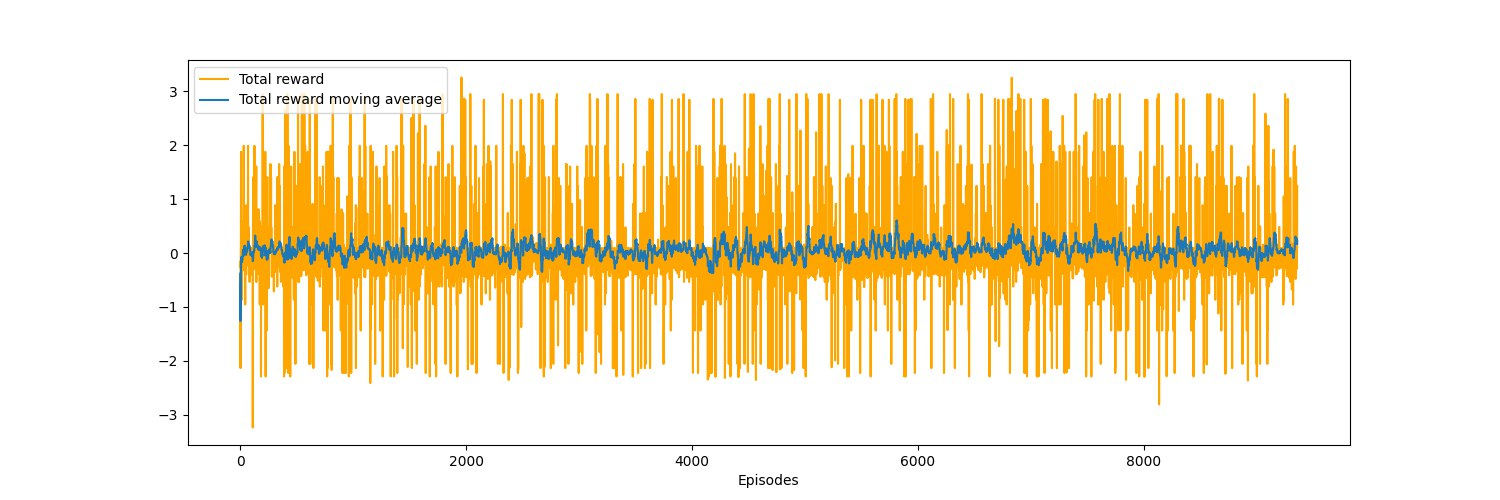

#### 20k episodi

Assuming that the number of training episodes was not adequate for the model to learn the target policy, a test was conducted with 20,000 episodes with a maximum number of steps of 20 actions for each episode (the other parameters were left to the configuration of default).

In order to train the DDQN on the department's cluster, the training was divided into sessions of 2500 episodes each, saving the weights at the end of the session and then reloading them at the beginning of the next one: this expedient made it possible to carry out the training without the Slurm job went into Out-Of-Memory.


#### Performance recap

The following table shows the results of the experiments carried out: the best result in terms of measured metrics was obtained following the test with 20,000 episodes.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**lr 1e-5**    | **9.1822** | **8.7603** | **0.1078**
**lr 1e-4**    | **7.7312** | **9.5924** | **0.1410**
**argmin**     | **16.6831** | **6.0483** | **0.0075**
**env con stessa immagine** | **14.0121** | **6.6658** | **0.0183**
**reward con MSE** | **5.3699** | **11.1078** | **0.1847**
**condizione di terminazione modificata** | **6.2999** | **20.1374** | **0.7912**
**20k episodi** | **1.2215** | **17.2619** | **0.7219**

## Performance analysis

To evaluate the effectiveness of the solution produced, some metrics calculated on the image produced compared to the reference one were evaluated. The calculated values ​​were then compared with those obtained with different methods addressing the same problem.

In addition, the images produced in output were compared with those designated by those who built the dataset as ground truth. These reference images were produced without the use of deep learning, but through various image enhancement methods.


### Analisi qualitativa


Performance analysis
To evaluate the effectiveness of the solution produced, some metrics calculated on the image produced compared to the reference one were evaluated. The calculated values ​​were then compared with those obtained with different methods addressing the same problem.

In addition, the images produced in output were compared with those designated by those who built the dataset as ground truth. These reference images were produced without the use of deep learning, but through various image enhancement methods.

Qualitative analysis
Qualitative analysis concerns the evaluation of non-quantifiable data, in this case the quality of the improved images produced by the DDQN.

Once the network which, following training, performed best on the validation set was identified, its effectiveness was tested on the images of the test set, a third set of images separate from the training and validation set.

5 random images were taken from the test set and input to the DQN evaluation. The evaluation of the improved images produced made it possible to qualitatively evaluate the performances.

In [ ]:
#qualitative analysis
TEST_Episodes = 5
ddqn.epsilon = 0 #setting epsilon to 0 to obtain only exploitation
max_test_episode_step = 10 #similar to the value used from the authors of the paper

for e_test in range(TEST_Episodes):
  state = env.reset()
  done = False
  step_count = 1
  while not done:
    action = ddqn.select_action(state) #use eval dqn for predicting optimal action
    new_state,_ = env.step(action) #apply action on the environment image
    done = ddqn.check_if_done(state) #check if image can be improved
    state = new_state #update state with new features
    if done or step_count >= max_test_episode_step: 
      env.render()
      break
    step_count += 1

### Analisi quantitativa

Quantitative analysis is done by using quantifiable values ​​to conduct the assessment. Specifically, the metrics used to conduct the analysis are MSE, PSNR and SSIM (already described above).

The values ​​are calculated in a similar way to what was done in the validation phase:

* DQN evaluation is used to improve the raw image until the stop condition is reached or the maximum number of steps is reached

* the value for the three metrics is calculated using the obtained image and the reference one

* the first two points are repeated for each image of the test set and then an average of the values ​​obtained for each metric is calculated

* the average values ​​obtained are used to compare the performance of the model to other solutions that have addressed the same problem

In [ ]:
#quantitative analysis
ddqn.epsilon = 0 #setting epsilon to 0 to obtain only exploitation
max_test_episode_step = 10 #similar to the value used from the authors of the paper
total_mse = total_psnr = total_ssim = 0 #initialize metrics total counter

for index, (raw_path,ref_path) in enumerate(zip(images_raw_test,images_ref_test)):
  state = env.reset(raw_path, ref_path)
  tot_rewards = 0
  done = False
  step_count = 1
  while not done:
    action = ddqn.select_action(state) #use eval dqn for predicting optimal action
    new_state, reward = env.step(action) #apply action on the environment image
    done = ddqn.check_if_done(state) #check if image can be improved
    tot_rewards += reward #update total reward
    state = new_state #update state with new features
    if done or step_count >= max_test_episode_step: 
      #calculate metrics for the obtained image
      mse = mean_squared_error(np.array(env.current_image), np.array(env.reference_image))
      psnr = peak_signal_noise_ratio(np.array(env.current_image), np.array(env.reference_image))
      ssim = structural_similarity(im1=np.array(env.current_image), im2=np.array(env.reference_image), multichannel=True)
      print("episode: {}/{}, steps: {}, episode reward: {}".format(index, len(images_raw_test), step_count, tot_rewards))
      total_mse += mse
      total_psnr += psnr
      total_ssim += ssim
      break
    step_count += 1

avg_mse = total_mse / len(images_raw_val)
avg_psnr = total_psnr / len(images_raw_val)
avg_ssim = total_ssim / len(images_raw_val)

print("lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(learning_rate,
                                                                          alpha,
                                                                          beta,
                                                                          episodes,
                                                                          episode_max_steps))
print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse,
                                                        avg_psnr,
                                                        avg_ssim))

## Comparison with other solutions

The following table shows the results obtained on the test set of various models proposed by the papers from which it was inspired that deal with the same problem.

As values ​​for the model implemented in this paper, those obtained in the testing phase from the model that presented the best performance in the validation phase were chosen.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | ---
WaterNet       | 0.7976 | 19.1130 | 0.7971
Water CycleGAN | 1.7298 | 15.7508 | 0.5210
Dense GAN      | 1.2152 | 17.28.43| 0.4426
**DDQN 20k episodi** | **2.1216** | **15.4687** | **0.6281**

Although the model has obtained an appreciable result on the validation set, on the test set the performances are not very interesting. The model fails to generalize (overfitting) and, although the result could also depend on the size of the training set which is too small, it is possible that by increasing the number of training episodes, the model achieves better performance.  

## Team contribution


In this section we wanted to summarize the contribution of the team:

* collection of Image Enhancement functions from different libraries

* implementation of an environment that has as state a pair composed of a reference image and a raw image on which the actions are performed

* implementation of a function that calculates the value (reward) which indicates the quality of the improvement made on the raw image compared to the reference image, i.e. if the image obtained is more or less similar to the ground truth

* implementation of the framework to do Underwater Image Enhancement, based on the use of a DDQN trained on a dataset of underwater images to learn the optimal policy for selecting the actions to apply on the current image of the environment

* training, validation and testing of the implemented network using different hyperparameter configurations and evaluating which allows to achieve the best performance

* comparison of the results obtained with those of methods that have addressed the same problem

##Errors/Problems

Reinforcement learning requires long training sessions to learn and also needs careful calibration of hyperparameters.

During the development of the project we took inspiration from the article from which the idea of ​​the project was born, while the authors' repository provided an implementation at times discordant from what is exposed in the article and the total reverse engineering of the code would have required a 'huge amount of time. For these two reasons it was decided to reimplement the system architecture.

Furthermore, the repository code could not be executed due to a missing module. Therefore it was not possible to verify the effective validity of the solution.

Some hyperparameters are not mentioned in the paper and have therefore been chosen independently. Some values ​​have instead been altered because they are considered not very sensible: for example, the article proposes to train the evaluation and update the target after each step. This means that the weights would be updated at each step and the fact of having two different models would not be exploited because they would always have the same weights.

The tests carried out on the DISI HPC cluster suggested the inability of the model to learn the desired behavior. The agent did not learn and, at a certain point, tended to always choose the same action in exploitation (this happened with any choice of parameters). It was thought that this was due to the too low number of training episodes, but it was impossible to conduct longer sessions due to the memory available for the Slurm job: in particular, the job running on the cluster stops after about 3-4 hours due to of an Out-Of-Memory error. It was not possible to change the amount of memory allocated to the job due to lack of permissions to execute the required commands.

**The test conducted by saving the weights at the end of the session and loading them at the start of the next training session showed that the model is able to learn, obtaining interesting results, but an even greater number of episodes are required to obtain excellent results.**

## Literature references



[1] Underwater Image Enhancement With Reinforcement Learning - https://ieeexplore.ieee.org/document/9751218

[2] Chongyi Li, Chunle Guo, Wenqi Ren, Runmin Cong, Junhui Hou, Sam Kwong, Dacheng Tao - 
An Underwater Image Enhancement Benchmark Dataset and Beyond - https://ieeexplore.ieee.org/document/8917818

[3] K. He, J. Sun, and X. Tang, “Single image haze removal using dark
channel prior,” IEEE Trans. Pattern Anal. Mach. Intell., vol. 33, no. 12,
pp. 2341–2353, Dec. 2011. - https://ieeexplore.ieee.org/document/5567108

[4] Van Hasselt, H., Guez, A., & Silver, D. (2016, February). Deep Reinforcement Learning with Double Q-Learning. In AAAI (Vol. 2, p. 5), - https://arxiv.org/pdf/1509.06461.pdf